## KITTI Dataset Tutorial

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from matplotlib import gridspec
from matplotlib import pyplot as plt
import PIL.Image as pil

### Load and visualize stereo images
Note: These are stereo pair images from the same timestamp.

In [ ]:
stereo_left_image_path = "data/kitti_example/2011_09_26/2011_09_26_drive_0048_sync/image_02/data/0000000000.png"
stereo_right_image_path = "data/kitti_example/2011_09_26/2011_09_26_drive_0048_sync/image_03/data/0000000000.png"

stereo_left_image = pil.open(stereo_left_image_path).convert('RGB')
stereo_right_image = pil.open(stereo_right_image_path).convert('RGB')

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(stereo_left_image)
plt.show()

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(stereo_right_image)
plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10)) 
grid = gridspec.GridSpec(2, 1, height_ratios=[1, 1], wspace=0.0, hspace=0.0, figure=fig)

# Plot camera image.
ax = plt.subplot(grid[0])
ax.imshow(stereo_left_image)
ax.set_xticklabels([])
ax.set_yticklabels([])

# Plot segmentation image.
ax = plt.subplot(grid[1])
ax.imshow(stereo_right_image)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

### Load and Visualize Lidar Data.
Note: Lidar is formatted as [N, 4] where N is the number of lidar points and 4 corresponds to x, y, z, lidar_intensity.

In [ ]:
import kitti_utils

lidar_data_path = 'data/kitti_example/2011_09_26/2011_09_26_drive_0048_sync/velodyne_points/data/0000000000.bin'
lidar_data = kitti_utils.load_lidar_points(lidar_data_path)

In [ ]:
import plotly.graph_objects as go
import plotly_utils

fig = go.Figure()
data = go.Scatter3d(x=lidar_data[:, 0], 
                    y=lidar_data[:, 1], 
                    z=lidar_data[:, 2], 
                    mode='markers',
                    marker=dict(size=1, color=lidar_data[:, 3], colorscale='Viridis'),
                    name='lidar')
fig.add_traces(data)

plotly_utils.setup_layout(fig)
fig.show()

### Loading IMU Data

In [ ]:
scene_path = 'data/kitti_example/2011_09_26/2011_09_26_drive_0048_sync/'

imu_data = kitti_utils.get_imu_data(scene_path, 0)
imu_data

In [ ]:
imu_df = kitti_utils.get_imu_dataframe(scene_path)
imu_df

### Visualizing Error (metrics)

In [3]:
from __future__ import absolute_import, division, print_function

import os
import glob
import numpy as np
import PIL.Image as pil
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kitti_utils as ku
import dataloader as dl
import overlay_lidar_utils as olu
import compute_photometric_error_utils as cpeu
import metrics as m
import cv2

import sys
sys.path.append('third_party/monodepth2')
from ResnetEncoder import ResnetEncoder
from DepthDecoder import DepthDecoder

import torch
from torchvision import transforms

from layers import disp_to_depth
from monodepth2_utils import download_model_if_doesnt_exist
from use_existingmodels import test_depth_model

-> Loading model from  models/mono_1024x320
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images


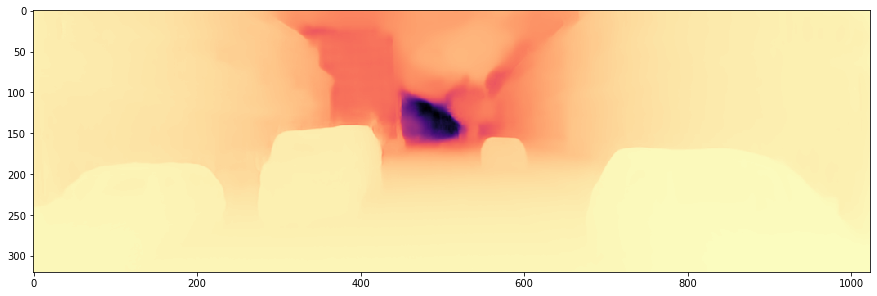

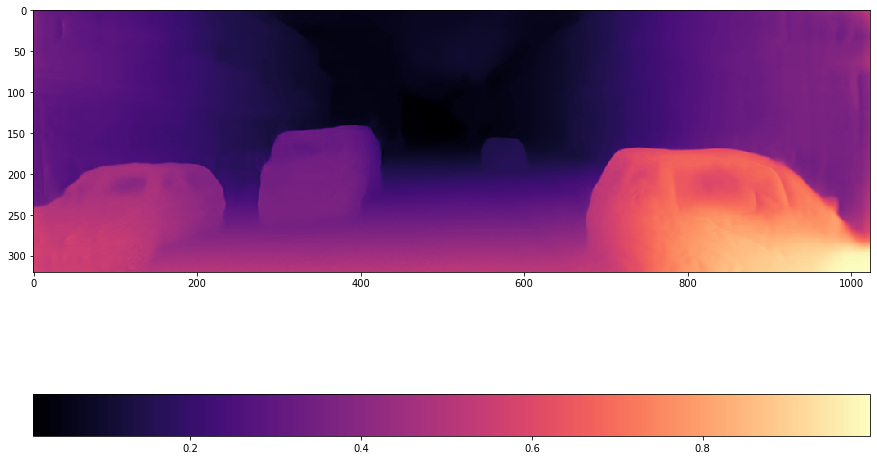

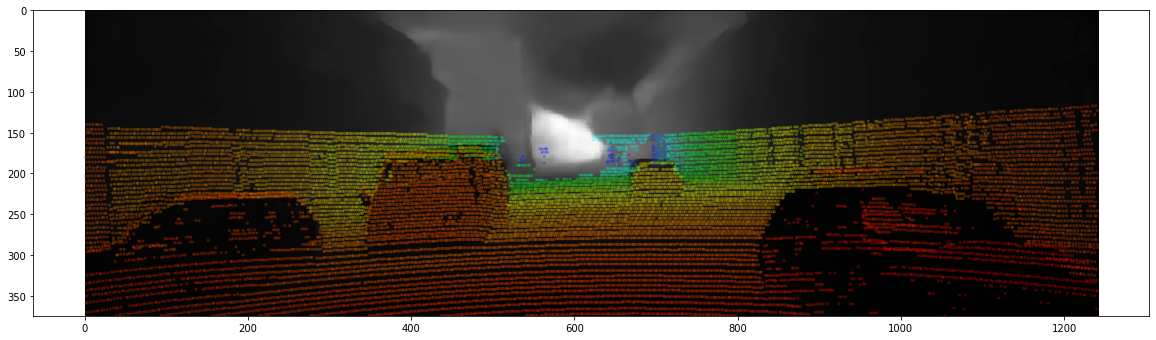

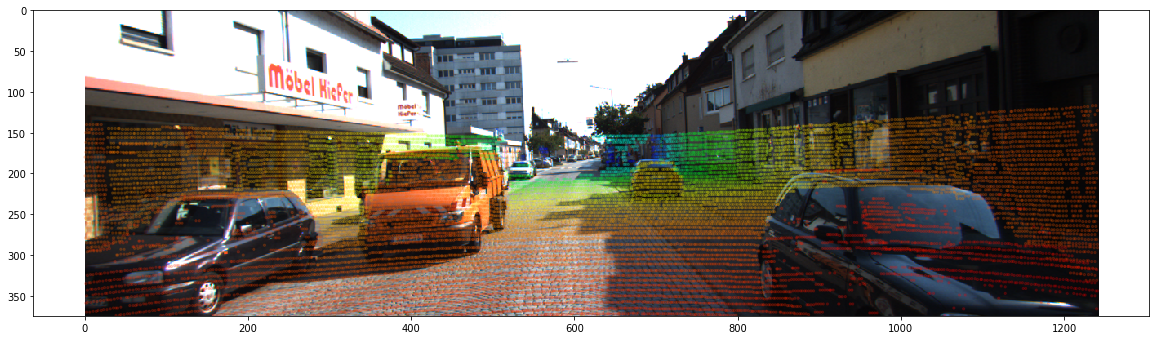

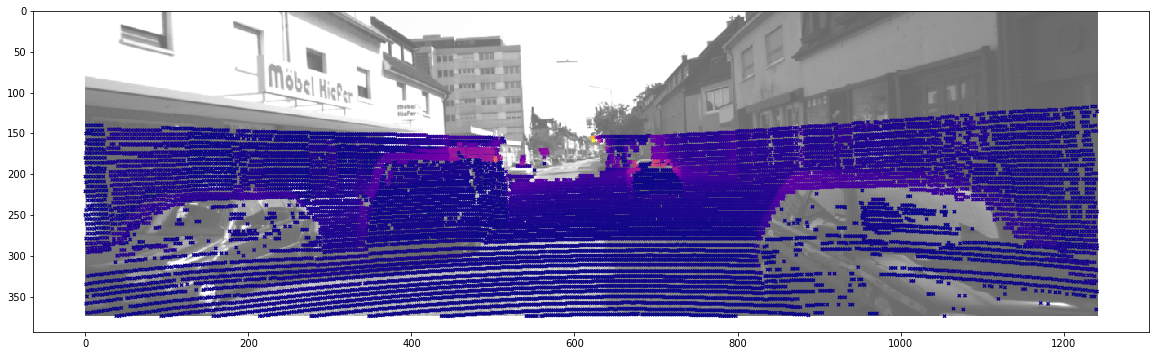

In [4]:
disparity, depth = test_depth_model('data/kitti_example/2011_09_26/2011_09_26_drive_0048_sync/image_02/data/0000000000.png', 'mono_1024x320', output_path='data', display_result = False, no_filesave = True)
date_path = 'data/kitti_example/2011_09_26/'
lidar_path = 'data/kitti_example/2011_09_26/2011_09_26_drive_0048_sync/velodyne_points/data/0000000000.bin'
original_image = mpimg.imread('data/kitti_example/2011_09_26/2011_09_26_drive_0048_sync/image_02/data/0000000000.png')


depth = depth * 31.257
plt.figure(figsize=(15, 15))
depth_image_arr = np.squeeze(depth)
# Display depth image
plt.imshow(depth_image_arr, cmap='magma_r')
plt.show()
# Display disparity image
plt.figure(figsize=(15, 15))
plt.imshow(np.squeeze(disparity), cmap='magma')
# Display colorbar (horizontal)
plt.colorbar(orientation='horizontal')
plt.show()
# Load LiDAR points
lidar_point_coord_velodyne = ku.load_lidar_points(lidar_path)
camera_image_from_velodyne = ku.compute_image_from_velodyne_matrices(date_path).get('stereo_left')
lidar_point_coord_camera_image, filtered_index = olu.generate_lidar_point_coord_camera_image(lidar_point_coord_velodyne, camera_image_from_velodyne, 1242, 375)
# Filter LiDAR points so that only ones in camera frame are kept
lidar_tgt = lidar_point_coord_camera_image[filtered_index]
# Upsample depth image to fit LiDAR
img = depth_image_arr.numpy()
resized_depth_arr = pil.fromarray(img)
final_resized_depth = np.array(resized_depth_arr.resize(size=(1242, 375)))
# Display depth and original image overlayed with LiDAR
plt.figure(figsize=(20, 20))
olu.plot_lidar_on_image(final_resized_depth, lidar_tgt, alpha=0.2)
plt.figure(figsize=(20, 20))
olu.plot_lidar_on_image(original_image, lidar_tgt, alpha=0.2)
# Calculate absolute error at each LiDAR point 
final_error = m.compute_error(final_resized_depth, lidar_tgt)[3]
# Display visualization that overlays absolute error at each LiDAR point on top of a grayscaled version of the original image
m.visualize_error(final_error, original_image, s=10)